In [1]:
import tensorflow as tf                  # TensorFlow

import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten,Dropout
from keras.layers import Conv2D,LSTM,BatchNormalization,MaxPooling2D,Reshape
from keras.utils import to_categorical
import matplotlib.pyplot as plt

2024-03-15 10:30:35.586743: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


(2115, 22, 1000)


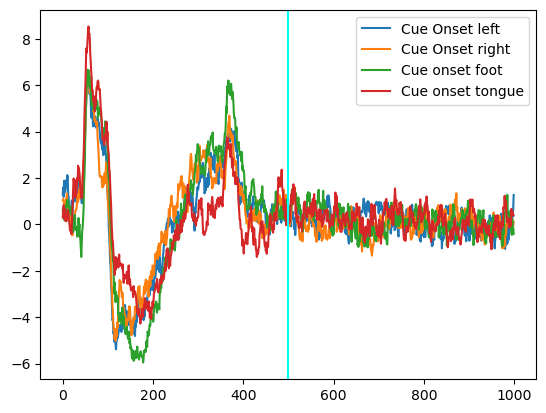

In [2]:
## Loading and visualizing the data

## Loading the dataset


X_test = np.load("project/X_test.npy")
y_test = np.load("project/y_test.npy")
person_train_valid = np.load("project/person_train_valid.npy")
X_train_valid = np.load("project/X_train_valid.npy")
print(X_train_valid.shape)
y_train_valid = np.load("project/y_train_valid.npy")
person_test = np.load("project/person_test.npy")

## Adjusting the labels so that 

# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

y_train_valid -= 769
y_test -= 769

## Visualizing the data

ch_data = X_train_valid[:,8,:]


class_0_ind = np.where(y_train_valid == 0)
ch_data_class_0 = ch_data[class_0_ind]
avg_ch_data_class_0 = np.mean(ch_data_class_0,axis=0)


class_1_ind = np.where(y_train_valid == 1)
ch_data_class_1 = ch_data[class_1_ind]
avg_ch_data_class_1 = np.mean(ch_data_class_1,axis=0)

class_2_ind = np.where(y_train_valid == 2)
ch_data_class_2 = ch_data[class_2_ind]
avg_ch_data_class_2 = np.mean(ch_data_class_2,axis=0)

class_3_ind = np.where(y_train_valid == 3)
ch_data_class_3 = ch_data[class_3_ind]
avg_ch_data_class_3 = np.mean(ch_data_class_3,axis=0)


plt.plot(np.arange(1000),avg_ch_data_class_0)
plt.plot(np.arange(1000),avg_ch_data_class_1)
plt.plot(np.arange(1000),avg_ch_data_class_2)
plt.plot(np.arange(1000),avg_ch_data_class_3)
plt.axvline(x=500, label='line at t=500',c='cyan')

plt.legend(["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])






In [3]:
def train_data_prep(X,y,sub_sample,average,noise):
    
    total_X = None
    total_y = None
    
    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,0:500]
    print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    
    
    total_X = X_max
    total_y = y
    print('Shape of X after maxpooling:',total_X.shape)
    
    # Averaging + noise 
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
        
    
    print('Shape of X after subsampling and concatenating:',total_X.shape)
    print('Shape of Y:',total_y.shape)
    return total_X,total_y


def test_data_prep(X):
    
    total_X = None
    
    
    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,0:500]
    print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, 2), axis=3)
    
    
    total_X = X_max
    print('Shape of X after maxpooling:',total_X.shape)
    
    return total_X




In [4]:
## Random splitting and reshaping the data

# First generating the training and validation indices using random splitting
ind_valid = np.random.choice(2115, 400, replace=False)
ind_train = np.array(list(set(range(2115)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(x_train, x_valid) = X_train_valid[ind_train], X_train_valid[ind_valid] 
(y_train, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]
print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)


## Preprocessing the dataset

X_train_prep, y_train_prep = train_data_prep(x_train,y_train,2,2,True)
X_valid_prep = test_data_prep(x_valid) 
X_test_prep = test_data_prep(X_test) 

print('\n')
# Converting the labels to categorical variables for multiclass classification
y_train = to_categorical(y_train_prep, 4)
y_valid = to_categorical(y_valid, 4)
y_test = to_categorical(y_test, 4)
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
x_train = X_train_prep.reshape(X_train_prep.shape[0], X_train_prep.shape[1], X_train_prep.shape[2], 1)
x_valid = X_valid_prep.reshape(X_valid_prep.shape[0], X_valid_prep.shape[1], X_valid_prep.shape[2], 1)
x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)

print('\n')


# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)


Shape of training set: (1715, 22, 1000)
Shape of validation set: (400, 22, 1000)
Shape of training labels: (1715,)
Shape of validation labels: (400,)
Shape of X after trimming: (1715, 22, 500)
Shape of X after maxpooling: (1715, 22, 250)
Shape of X after averaging+noise and concatenating: (3430, 22, 250)
Shape of X after subsampling and concatenating: (6860, 22, 250)
Shape of Y: (6860,)
Shape of X after trimming: (400, 22, 500)
Shape of X after maxpooling: (400, 22, 250)
Shape of X after trimming: (443, 22, 500)
Shape of X after maxpooling: (443, 22, 250)


Shape of training labels after categorical conversion: (6860, 4)
Shape of validation labels after categorical conversion: (400, 4)
Shape of test labels after categorical conversion: (443, 4)
Shape of training set after adding width info: (6860, 22, 250, 1)
Shape of validation set after adding width info: (400, 22, 250, 1)
Shape of test set after adding width info: (443, 22, 250, 1)


Shape of training set after dimension reshaping: 

In [5]:
# Building the CNN model using sequential class
cnn_model = Sequential()

# Conv. block 1
cnn_model.add(Conv2D(filters=25, kernel_size=(5,5), padding='same', activation='elu',\
                                 input_shape=(250,1,22)))
cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(0.6))

# Conv. block 2
cnn_model.add(Conv2D(filters=50, kernel_size=(5,5), padding='same', activation='elu'))
cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(0.6))

# Conv. block 3
cnn_model.add(Conv2D(filters=100, kernel_size=(5,5), padding='same', activation='elu'))
cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(0.6))

# Conv. block 4
cnn_model.add(Conv2D(filters=200, kernel_size=(5,5), padding='same', activation='elu'))
cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(0.6))

# FC
cnn_model.add(Flatten()) # Adding a flattening operation to the output of CNN block
cnn_model.add(Dropout(0.6))


# Output layer with Softmax activation 
cnn_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation


# Printing the model summary
cnn_model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 250, 1, 25)        13775     
                                                                 
 max_pooling2d (MaxPooling2  (None, 84, 1, 25)         0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 84, 1, 25)         100       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 84, 1, 25)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 84, 1, 50)         31300     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 28, 1, 50)         0

In [6]:
# Model parameters
learning_rate = 1e-3
epochs = 100
cnn_optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

In [7]:
# Load the TensorBoard extension
%load_ext tensorboard
# we will use the datetime to label logs
import datetime

# run this cell to clear all previous logs
!rm -rf ./logs/

# create a tensorboard callback to visualize training
tb_callback = tf.keras.callbacks.TensorBoard(log_dir="logs2/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"), histogram_freq=1)

# anneals the learning rate
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(patience = 10, factor = 0.5)  # reduces by a factor of 10 if validation loss doesn't improve for 10 epochs

# checkpoint saving callback
save_cb = tf.keras.callbacks.ModelCheckpoint(
    'models2/checkpoint_{epoch:02d}_{val_loss:0.2f}',   # where to save models
    monitor= 'val_loss',
    verbose = 0,
    save_best_only = False,
    save_weights_only = False,
    save_freq='epoch'   # saves every epoch
)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)

In [8]:
# Compiling the model
cnn_model.compile(loss='categorical_crossentropy',
                 optimizer=cnn_optimizer,
                 metrics=['accuracy'])

# Training and validating the model
cnn_model_results = cnn_model.fit(x_train,
             y_train,
             batch_size=64,
             epochs=epochs,
             validation_data=(x_valid, y_valid), 
             callbacks=[early_stopping], verbose=True)




Epoch 1/100
108/108 [==============================] - 21s 151ms/step - loss: 3.1108 - accuracy: 0.2729 - val_loss: 1.3786 - val_accuracy: 0.3100
Epoch 2/100
108/108 [==============================] - 16s 147ms/step - loss: 2.2935 - accuracy: 0.2936 - val_loss: 1.4186 - val_accuracy: 0.3125
Epoch 3/100
108/108 [==============================] - 15s 139ms/step - loss: 1.7514 - accuracy: 0.3114 - val_loss: 1.3466 - val_accuracy: 0.3600
Epoch 4/100
108/108 [==============================] - 16s 146ms/step - loss: 1.4848 - accuracy: 0.3401 - val_loss: 1.3111 - val_accuracy: 0.3700
Epoch 5/100
108/108 [==============================] - 16s 149ms/step - loss: 1.3904 - accuracy: 0.3710 - val_loss: 1.2853 - val_accuracy: 0.3550
Epoch 6/100
108/108 [==============================] - 15s 138ms/step - loss: 1.3162 - accuracy: 0.4077 - val_loss: 1.2178 - val_accuracy: 0.4625
Epoch 7/100
108/108 [==============================] - 16s 150ms/step - loss: 1.2969 - accuracy: 0.4223 - val_loss: 1.2234 -

Epoch 57/100
108/108 [==============================] - 13s 118ms/step - loss: 0.8093 - accuracy: 0.6789 - val_loss: 0.8512 - val_accuracy: 0.6575
Epoch 58/100
108/108 [==============================] - 13s 119ms/step - loss: 0.8109 - accuracy: 0.6796 - val_loss: 0.8576 - val_accuracy: 0.6775
Epoch 59/100
108/108 [==============================] - 12s 112ms/step - loss: 0.8172 - accuracy: 0.6748 - val_loss: 0.8365 - val_accuracy: 0.6600
Epoch 60/100
108/108 [==============================] - 12s 116ms/step - loss: 0.7978 - accuracy: 0.6818 - val_loss: 0.8939 - val_accuracy: 0.6350
Epoch 61/100
108/108 [==============================] - 12s 108ms/step - loss: 0.8107 - accuracy: 0.6759 - val_loss: 0.8906 - val_accuracy: 0.6275
Epoch 62/100
108/108 [==============================] - 13s 117ms/step - loss: 0.7840 - accuracy: 0.6880 - val_loss: 0.8612 - val_accuracy: 0.6500
Epoch 63/100
108/108 [==============================] - 13s 117ms/step - loss: 0.7992 - accuracy: 0.6802 - val_loss: 0

In [9]:
# tensorboard --logdir logs2

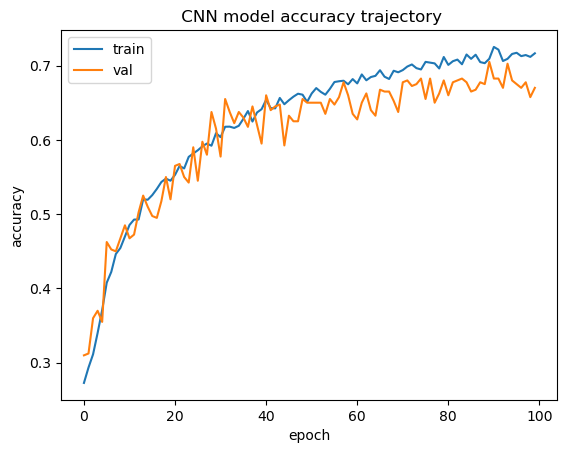

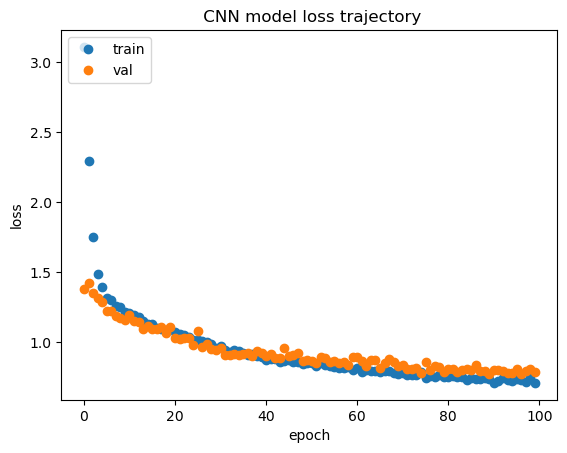

In [10]:
import matplotlib.pyplot as plt

# Plotting accuracy trajectory
plt.plot(cnn_model_results.history['accuracy'])
plt.plot(cnn_model_results.history['val_accuracy'])
plt.title(' CNN model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(cnn_model_results.history['loss'],'o')
plt.plot(cnn_model_results.history['val_loss'],'o')
plt.title(' CNN model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [12]:
## Testing the hybrid CNN-LSTM model

hybrid_cnn_lstm_score = cnn_model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the hybrid CNN-LSTM model:',hybrid_cnn_lstm_score[1])

Test accuracy of the hybrid CNN-LSTM model: 0.7088035941123962


In [ ]:
model = keras.models.load_model('models2/checkpoint_118_0.74')

In [ ]:
## Testing the hybrid CNN-LSTM model

hybrid_cnn_lstm_score = model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the hybrid CNN-LSTM model:',hybrid_cnn_lstm_score[1])